<div style="border:solid green 2px; padding: 20px">

<b>Привет, Михаил! Поздравляю с выполнением очередного проекта!</b>

Меня зовут Петр Раздобреев и я буду проверять твою работу. Попробую помочь сделать тебе её еще лучше! В Практикуме принято общени на ты, но если это дискомфортно, то сообщи об этом)

Ниже ты найдешь мои комментарии - пожалуйста, не перемещай, не изменяй и не удаляй их. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ Так выделены небольшие замечания.Такие замечания в проекте допустимы, это пространство для улучшений в будущем.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Так я выделяю успешные идеи.</div>

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
    



# Проект 6 - Procrastinate Pro+

## Введение

**Описание проекта**

Несколько прошлых месяцев бизнес Procrastinate Pro+ постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Надо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей. При решении предположим, что смотрим на данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

**Описание данных**

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

1. `User Id` — уникальный идентификатор пользователя
2. `Device` — категория устройства пользователя
3. `Session start` — дата и время начала сессии
4. `Session End` — дата и время окончания сессии
5. `Channel` — идентификатор рекламного источника, из которого пришел пользователь
6. `Region` - страна пользователя

Таблица `orders_log_short` (информация о заказах):

1. `User Id` — уникальный id пользователя, который сделал заказ
2. `Event Dt` — дата и время покупки
3. `Revenue` — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

1. `Channel` — идентификатор рекламного источника
2. `Dt` — дата
3. `Costs` — затраты на этот рекламный источник в этот день

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them.
try:
    raw_visits = pd.read_csv('visits_info_short.csv')
    raw_orders = pd.read_csv('orders_info_short.csv')
    raw_costs = pd.read_csv('costs_info_short.csv')
except:
    raw_visits = pd.read_csv('/datasets/visits_info_short.csv')
    raw_orders = pd.read_csv('/datasets/orders_info_short.csv')
    raw_costs = pd.read_csv('/datasets/costs_info_short.csv')
    
# Constants, which we will need later.
FIG_WIDTH = 10
FIG_HEIGHT = 5
OBSERVATION_DATE = datetime(2019, 11, 1)
HORIZON_DAYS = 14

In [2]:
# Let's have a look what is inside.
for data_frame in [raw_visits, raw_orders, raw_costs]:
    display(data_frame.head(3))
    raw_visits.info()
    print(50 * '-')

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


Очень красивые таблицы. Причешем их немного.

In [3]:
# Datasets, which we will clean up.
df_visits, df_orders, df_costs = raw_visits.copy(), raw_orders.copy(), raw_costs.copy()

# Snake case for column names, no spaces. 
for data_frame in [df_visits, df_orders, df_costs]:
    data_frame.columns = data_frame.columns.str.lower()
    data_frame.columns = data_frame.columns.str.replace(' ', '_')
    
# Set data types.
df_visits = df_visits.astype({'user_id': 'object',
                              'region': 'object',
                              'device': 'object',
                              'channel': 'object',
                              'session_start': 'datetime64[D]',
                              'session_end': 'datetime64[D]'})

df_orders = df_orders.astype({'user_id': 'object',
                              'event_dt': 'datetime64[D]',
                              'revenue': 'float64'})

df_costs = df_costs.astype({'dt': 'datetime64[D]',
                            'channel': 'object',
                            'costs': 'float64'})

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 
    
* Проблема названий столбцов ведь только в том, что имеются пробелы и заглавные буквы, соответственно можно было бы обойтись и без `rename`
* Могу предложить такой вариант `visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]`
    
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Привет! Давай на ты. А где там был rename? Я только типы данных задал через `astype`.

</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера v2:</b>⛅️ 

Здравствуй, а я ошибся получается, перепутал `astype` и `rename`, очень похож формат записи)
</div>

Скорей всего, нам достались нормальные данные без аномалий. Но из большого любопытства проверим.

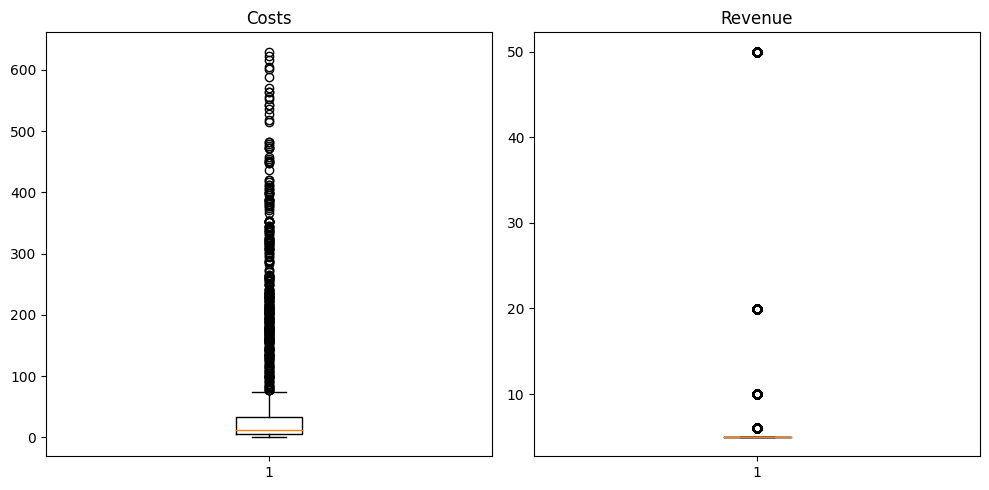

In [4]:
# Boxplots first.
def fun_get_boxplots_for_columns(columns: list,
                                 titles: list,
                                 num_rows: int,
                                 num_columns: int):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        columns (List): list of columns to plot from a DataFrame.
        
        titles (List): list of titles for subplots.
        
        num_rows (int): number of rows in subplots.
        
        num_columns (int): number of columns in subplots.
    """
    # Create subplots.
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(FIG_WIDTH, FIG_HEIGHT))

    # Popuplate subplots.
    for i, ax in enumerate(axs.flat):
        ax.boxplot(columns[i].dropna())
        ax.set_title(titles[i])

    plt.tight_layout()

fun_get_boxplots_for_columns([df_costs.costs, df_orders.revenue],
                             ['Costs', 'Revenue'],
                             1, 2)

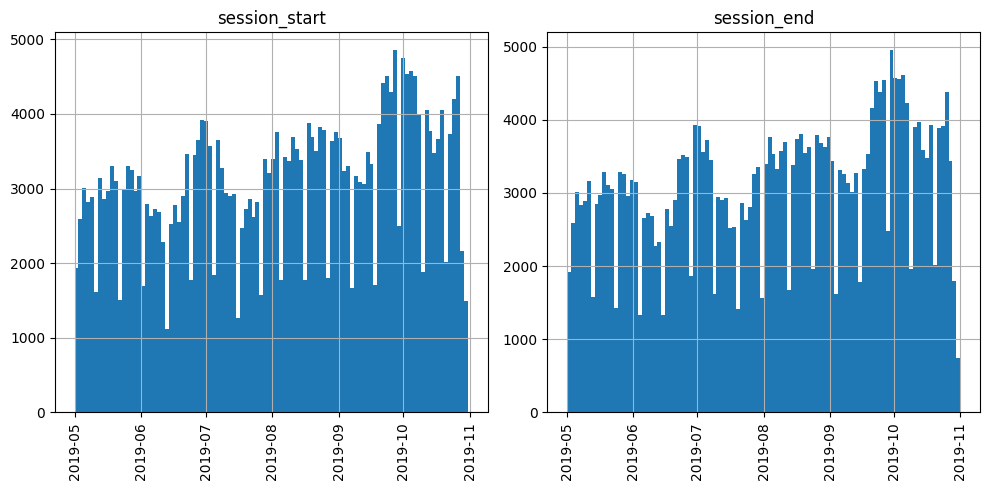

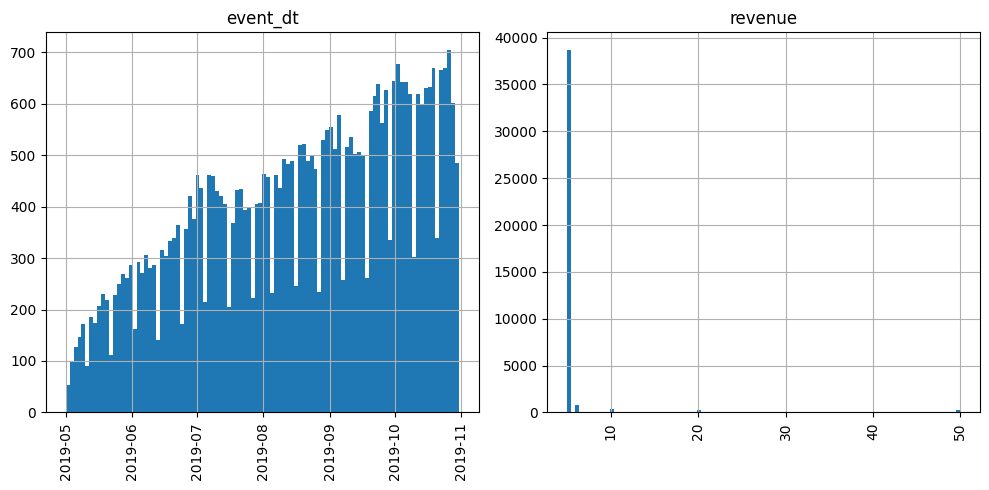

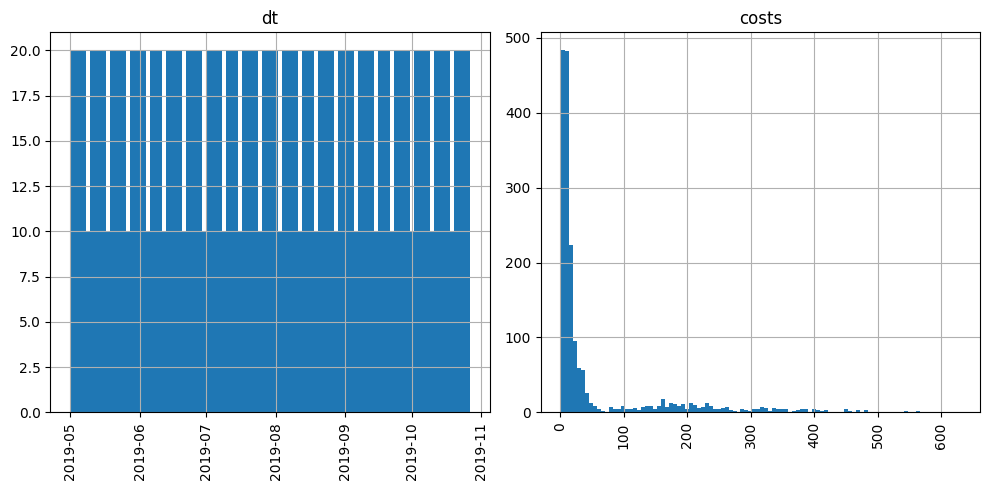

In [5]:
# Histograms.
for data_frame in [df_visits, df_orders, df_costs]:
    data_frame.hist(bins=100,
                    figsize=(FIG_WIDTH, FIG_HEIGHT),
                    xrot=90)
    plt.tight_layout()

Любопытство нас не подвело. Несколько наблюдений: во-первых, частота визитов и заказов растет - это видно по гистрограммам сессий и дат заказов. Во-вторых, что-то интересное происходит с нашей выручной и издержками - у нас есть выборосы в первом случае и странный хвост во втором.

Оставим цифры в покое, т.к. пока непонятно, что делать с этими хвостами. Но будем держать в уме такие аномалии - возможно, они создадут нам проблемы в ходе анализа.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
* Крупных платящих называют китами, в принципе они всегда бывают и это хорошо для проекта, да их совсем немного, но они имеются).

* Про затраты, просто неравномерные затраты по каналам изо дня в день и это дало столь длинный подозрительный хвост)</div>


## Функции для расчетов

Во время наших приключений нам придется работать с несколькими функциями. Объявим их заранее и немного приведем в порядок.

In [6]:
# User profiles.
def fun_get_profiles(sessions: pd.DataFrame,
                     orders: pd.DataFrame,
                     costs: pd.DataFrame) -> pd.DataFrame:
    """
    This function returns a dataframe of customer profiles from three input dataframes.
    1. For each unique user the function identifies what was the first time, channel, device and region recorded.
    2. Then it adds a 'payer' flag if a user have placed and order before.
    3. Then it calculates number of people in a cohort (assuming a cohort is unique for a first interaction date and channel).
    4. Then for each cohort it pulls ad costs and calculates acquisition cost per unique user.
    5. Finally, all previous steps are merged into a single dataframe of customer profiles.

    Args:
        sessions (DataFrame): each row is a record of site interactions by a unique user.
        Has to have columns 'user_id', 'region', 'device', 'channel', 'session_start', 'session_end'.
        
        orders (DataFrame): each row is a purchase by a unique user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        costs (DataFrame): each row is a money spent on a channel per day.
        Has to have columns 'user_id', 'event_dt', 'revenue'.

    Returns:
        profiles (DataFrame): each row is a record about a unique user:
        where and when he/she came from, if they have placed an order and what was acquistion cost.
        It has columns 'user_id', 'channel', 'device', 'region', 'payer', 'acquistion_cost'.
    """
    profiles = pd.pivot_table(data=sessions.sort_values(by=['user_id', 'session_start']),
                              index='user_id',
                              aggfunc={'session_start': 'first',
                                       'channel': 'first',
                                       'device': 'first',
                                       'region': 'first'}) \
                 .rename(columns={'session_start': 'first_ts'}) \
                 .reset_index()

    profiles['dt'] = profiles['first_ts'].astype('datetime64[D]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    profiles = profiles.drop(columns=['first_ts'])

    cohort_size = pd.pivot_table(data=profiles,
                                 index=['dt', 'channel'],
                                 aggfunc={'user_id': 'nunique'}) \
                    .rename(columns={'user_id': 'unique_users'}) \
                    .reset_index()                 

    costs = pd.merge(costs,
                     cohort_size,
                     on=['dt', 'channel'],
                     how='left')

    costs['acquisition_cost'] = costs.costs / costs.unique_users

    profiles = pd.merge(profiles,
                        costs[['dt', 'channel', 'acquisition_cost']],
                        on=['dt', 'channel'],
                        how='left')

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [7]:
# Retention.
def fun_get_retention(profiles: pd.DataFrame,
                      sessions: pd.DataFrame,
                      observation_date: datetime,
                      horizon_days: int,
                      dimensions=[],
                      ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets user retention by user lifetime (horizon_days) based on user profiles and sessions, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get retention for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        sessions (DataFrame): each row is a record of site interactions by a unique user.
        Has to have columns 'user_id', 'region', 'device', 'channel', 'session_start', 'session_end'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): retention will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): retention will be calculated for each cohort split by these dimensions.
        By default only 'payer' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate retention for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        retention_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        retention_by_dimension (DataFrame): pivot table of retention by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding retention value.
        It has dimensions as indicies, 'cohort_size' and then retention per each day of user lifetime.
        
        retention_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how retention
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
    """
    dimensions = ['payer'] + dimensions

    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    retention_raw = pd.merge(profiles_in_scope,
                             sessions[['user_id', 'session_start']],
                             on='user_id',
                             how='left')
    
    retention_raw['lifetime'] = (retention_raw.session_start - retention_raw.dt).dt.days

    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int) -> pd.DataFrame:
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of retention by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_retention. 
            Has to have columns 'user_id', 'lifetime' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_retention that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate retention.
            E.g.: 7 days will mean that df_grouped will have retention for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_retention.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with % of users retained.
        """ 
        df_grouped = pd.pivot_table(data=df,
                                    index=dims,
                                    columns='lifetime',
                                    values='user_id',
                                    aggfunc='nunique')

        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
        
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)
                   
        df_grouped = df_grouped.div(df_grouped.cohort_size, axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        
        return df_grouped

    retention_by_dimension = fun_group_by_dimensions(retention_raw, dimensions, horizon_days)
    retention_by_dimension_in_time = fun_group_by_dimensions(retention_raw, dimensions + ['dt'], horizon_days)

    return retention_raw, retention_by_dimension, retention_by_dimension_in_time

In [8]:
# Conversion.
def fun_get_conversion(profiles: pd.DataFrame,
                       purchases: pd.DataFrame,
                       observation_date: datetime,
                       horizon_days: int,
                       dimensions=[],
                       ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets user conversion by user lifetime (horizon_days) based on user profiles and purchases, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get conversion for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        purchases (DataFrame): each row is a record of an order placed by a user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): conversion will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): conversion will be calculated for each cohort split by these dimensions.
        By default only 'cohort' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate conversion for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        conversion_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        conversion_by_dimension (DataFrame): pivot table of conversion by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding conversion value.
        It has dimensions as indicies, 'cohort_size' and then conversion per each day of user lifetime.
        
        conversion_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how conversion
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
    """
    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    first_purchases = pd.pivot_table(data=purchases.sort_values(by=['user_id', 'event_dt']),
                                     index='user_id',
                                     aggfunc={'event_dt': 'first'}) \
                        .reset_index()

    conversion_raw = pd.merge(profiles_in_scope,
                              first_purchases[['user_id', 'event_dt']],
                              on='user_id',
                              how='left')
    
    conversion_raw['lifetime'] = (conversion_raw.event_dt - conversion_raw.dt).dt.days

    # Group by cohorts by default. Otherwise grouped data will be weird.
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int) -> pd.DataFrame:
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of conversion by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_conversion. 
            Has to have columns 'user_id', 'lifetime' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_conversion that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate conversion.
            E.g.: 7 days will mean that df_grouped will have conversion for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_conversion.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with % of users converted.
        """
        df_grouped = pd.pivot_table(data=df,
                                    index=dims,
                                    columns='lifetime',
                                    values='user_id',
                                    aggfunc='nunique')
        
        # Conversion in cummulative (in comparison to retention for example).
        df_grouped = df_grouped.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
       
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)
                       
        df_grouped = df_grouped.div(df_grouped['cohort_size'], axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        
        return df_grouped

    conversion_by_dimensions = fun_group_by_dimensions(conversion_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    converstion_by_dimension_in_time = fun_group_by_dimensions(conversion_raw, dimensions + ['dt'], horizon_days)

    return conversion_raw, conversion_by_dimensions, converstion_by_dimension_in_time

In [9]:
# Lifetime value.
def fun_get_ltv(profiles: pd.DataFrame,
                purchases: pd.DataFrame,
                observation_date: datetime,
                horizon_days: int,
                dimensions=[],
                ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets ltv and roi by user lifetime (horizon_days) based on user profiles and purchases, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get ltv/roi for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        purchases (DataFrame): each row is a record of an order placed by a user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): ltv will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): ltv will be calculated for each cohort split by these dimensions.
        By default only 'cohort' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate ltv for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        ltv_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        ltv_by_dimension (DataFrame): pivot table of ltv by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding ltv value.
        It has dimensions as indicies, 'cohort_size' and then ltv per each day of user lifetime.
        
        ltv_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how ltv
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
        
        roi_by_dimension (DataFrame): the same as ltv, but divided by cac.
        
        roi_by_dimension_in_time (DataFrame): the same as ltv, but divided by cac.
    """    
    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    ltv_raw = pd.merge(profiles_in_scope,
                       purchases[['user_id', 'event_dt', 'revenue']],
                       on='user_id',
                       how='left')
    
    ltv_raw['lifetime'] = (ltv_raw.event_dt - ltv_raw.dt).dt.days
    
    # Group by cohorts by default. Otherwise grouped data will be weird.
    if len(dimensions) == 0:
        ltv_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int):
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of ltv and roi by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_ltv. 
            Has to have columns 'user_id', 'lifetime', 'revenue' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_ltv that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate ltv.
            E.g.: 7 days will mean that df_grouped will have ltv for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_ltv.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with ltv.
            
            roi_by_dimensions (DataFrame): output dataframe of grouped_roi - the same as ltv, but divided by cac.
        """
        df_grouped = pd.pivot_table(df,
                                    index=dims,
                                    columns='lifetime',
                                    values='revenue',
                                    aggfunc='sum')
        
        # LTV in cummulative (in comparison to retention for example).
        df_grouped = df_grouped.fillna(0).cumsum(axis=1)

        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
        
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)

        df_grouped = df_grouped.div(df_grouped['cohort_size'], axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        df_cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        df_cac = pd.pivot_table(df_cac,
                                index=dims,
                                aggfunc={'acquisition_cost': 'mean'}) \
                   .rename(columns={'acquisition_cost': 'cac'})

        df_roi = df_grouped.div(df_cac.cac, axis=0)
        df_roi = df_roi[~df_roi['cohort_size'].isin([np.inf])]
        df_roi['cohort_size'] = cohort_sizes
        df_roi['cac'] = df_cac.cac
        df_roi = df_roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return df_grouped, df_roi

    ltv_by_dimensions, roi_by_dimensions = fun_group_by_dimensions(ltv_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    ltv_by_dimensions_in_time, roi_by_dimension_in_time = fun_group_by_dimensions(ltv_raw, dimensions + ['dt'], horizon_days)

    return ltv_raw, ltv_by_dimensions, ltv_by_dimensions_in_time, roi_by_dimensions, roi_by_dimension_in_time

In [10]:
# Rolling mean.
def fun_apply_rolling_mean(df: pd.DataFrame,
                           window: int) -> pd.DataFrame:
    """
    This function applies a rolling average with a specified window to selected columns from a dataframe.

    Args:
        df (DataFrame): dataframe in question.
        window (int): how many rows will be used to calculate average.

    Returns:
        df (DataFrame): output dataframe with a new (or overwritten) column of rolling average values. 
    """
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [11]:
# Plot retention.
def fun_plot_retention(retention_by_dimension: pd.DataFrame,
                       retention_by_dimension_in_time: pd.DataFrame,
                       horizon_days: int,
                       window=7):
    """
    This function plots user retention across available dimensions. It will produce 4 subplots:
    Subplot(2, 2, 1) - retention of paying users per lifetime.
    Subplot(2, 2, 2) - retention of non-paying users per lifetime.
    Subplot(2, 2, 3) - paying user retention on the last day of horizon_days per day.
    Subplot(2, 2, 4) - non-paying user retention on the last day of horizon_days per day.

    Args:
        retention_by_dimension (DataFrame): see fun_get_retention.
        retention_by_dimension_in_time (DataFrame): see fun_get_retention.
        horizon_days (int): see fun_get_retention.
        window (int, optional): see fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT * 2))

    retention_by_dimension = retention_by_dimension.drop(columns=['cohort_size', 0])
    
    # Keep only needed lifetime.
    retention_by_dimension_in_time = retention_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]

    # Add 'All users' cohort dimension if it doesn't exist. Otherwise it won't plot correctely.
    if retention_by_dimension.index.nlevels == 1:
        retention_by_dimension['cohort'] = 'All users'
        retention_by_dimension = retention_by_dimension.reset_index() \
                                                       .set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention_by_dimension.xs(True,
                              level="payer",
                              axis=0) \
                          .T \
                          .plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetimme')
    plt.title('Retention of paying users')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention_by_dimension.xs(False,
                              level="payer",
                              axis=0) \
                          .T \
                          .plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    ax3 = plt.subplot(2, 2, 3)
    # Get column names for a pivot table.
    columns = [
        name
        for name in retention_by_dimension_in_time.index.names
        if name not in ['dt', 'payer']
        ]
    
    filtered_data = pd.pivot_table(data=retention_by_dimension_in_time.xs(True,
                                                                          level="payer",
                                                                          axis=0,
                                                                          drop_level=False),
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Paying retention on day {}'.format(horizon_days))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = pd.pivot_table(data=retention_by_dimension_in_time.xs(False,
                                                                          level="payer",
                                                                          axis=0,
                                                                          drop_level=False),
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title('Non-paying retention on day {}'.format(horizon_days))    
    
    plt.tight_layout()
    plt.show()

In [12]:
# Plot conversion.
def fun_plot_conversion(conversion_by_dimension: pd.DataFrame,
                        conversion_by_dimension_in_time: pd.DataFrame,
                        horizon_days: int,
                        window=7):
    """
    This function plots user conversion across available dimensions. It will produce 2 subplots:
    Subplot(2, 2, 1) - user conversion per lifetime.
    Subplot(2, 2, 2) - user conversion on the last day of horizon_days_days per day.

    Args:
        conversion_by_dimension (pd.DataFrame): see fun_get_conversion.
        conversion_by_dimension_in_time (pd.DataFrame): see fun_get_conversion.
        horizon_days (int): see fun_get_conversion.
        window (int, optional): fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

    conversion_by_dimension = conversion_by_dimension.drop(columns=['cohort_size'])
    
    # Keep only needed lifetime.
    conversion_by_dimension_in_time = conversion_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion_by_dimension.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name 
        for name in conversion_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=conversion_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion on day {}'.format(horizon_days))

    plt.tight_layout()
    plt.show()

In [13]:
# Plot LTV and ROI.
def fun_plot_ltv_roi(ltv_by_dimension: pd.DataFrame,
                     ltv_by_dimension_in_time: pd.DataFrame,
                     roi_by_dimension: pd.DataFrame,
                     roi_by_dimension_in_time: pd.DataFrame,
                     horizon_days: int,
                     window=7):
    """
    This function plots ltv and roi across available dimensions. It will produce 5 subplots:
    Subplot(2, 3, 1) - ltv per user lifetime.
    Subplot(2, 3, 2) - ltv on the last day of horizon_days per day.
    Subplot(2, 3, 3) - cac per date.
    Subplot(2, 3, 4) - roi per user lifetime.
    Subplot(2, 3, 5) - roi on the last day of horizon_days per day.

    Args:
        ltv_by_dimension (DataFrame): see fun_get_ltv.
        ltv_by_dimension_in_time (DataFrame): see fun_get_ltv.
        roi_by_dimension (DataFrame): see fun_get_ltv.
        roi_by_dimension_in_time (DataFrame): see fun_get_ltv.
        horizon_days (int): see fun_get_ltv.
        window (int, optional): see fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT * 2))

    ltv_by_dimension = ltv_by_dimension.drop(columns=['cohort_size'])
    ltv_by_dimension_in_time = ltv_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]
    cac_history = roi_by_dimension_in_time[['cac']]
    roi_by_dimension = roi_by_dimension.drop(columns=['cohort_size', 'cac'])
    roi_by_dimension_in_time = roi_by_dimension_in_time.drop(columns=['cohort_size', 'cac'])[[horizon_days - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv_by_dimension.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name
        for name in ltv_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=ltv_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User LTV on day {}'.format(horizon_days))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name
        for name in cac_history.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=cac_history,
                                   index='dt',
                                   columns=columns,
                                   values='cac',
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User acquisition cost')

    ax4 = plt.subplot(2, 3, 4)
    roi_by_dimension.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [
        name
        for name in roi_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=roi_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Acquisition date')
    plt.title('User ROI on day {}'.format(horizon_days))

    plt.tight_layout()
    plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
        
Все необходимые функции были заданы, можно приступать к анализу. В принципе можно было добавить `markdown` заголовков, чтобы разграничить функции и упростить поиск нужной

</div>

## Исследовательский анализ данных

### Профили пользователей

Найдем профили пользователей, определим минимальную и максимальную дату привлечения.

Нас интересует:
1. Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
2. Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
3. По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [14]:
# Let's see how it looks.
df_profiles = fun_get_profiles(df_visits, df_orders, df_costs)
display(df_profiles.head())

,user_id,channel,device,region,dt,month,payer,acquisition_cost
0,599326,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [15]:
print('Minimum acquisition date is', min(df_profiles.dt.dt.date))
print('Maximum acquisition date is', max(df_profiles.dt.dt.date))

Minimum acquisition date is 2019-05-01
Maximum acquisition date is 2019-10-27


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Отлично, что проверили корректность временного интервала. Соответствует ли этот период указанному в задании? Хотелось бы в проекте видеть акцент на этом моменте. 
</div>

Похоже, нас не обманули: в датасете у нас действительно уникальные пользователи, привлеченные с 1 мая по 27 октября 2019 года. Всего, их было более 150К. Хороший результат за 5 месяцев?

In [16]:
def fun_plot_profiles(profiles: pd.DataFrame,
                      dimensions=['region']):
    """
    This function plots how many unique paying and non-paying users we have across selected dimensions.
    Each dimension will be plotted on a separate row. For each row there will be 2 bar-subplots:
    left for paying users and right for non-paying users.

    Args:
        profiles (DataFrame): see fun_get_profiles for details.
        dimensions (list, optional): list of dimensions of interest. Defaults to ['region'].
    """
    num_of_rows = len(dimensions)
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT * num_of_rows))
    axes = []
    i_subplot = 1
    
    for dimension in dimensions:            
        for payer_status in [True, False]:
            # If plot is on the right, then take y-axis from the left and set a different bar-color.
            if payer_status == True:
                ax = fig.add_subplot(num_of_rows, 2, i_subplot)
                bar_color = 'orange'
            else: 
                ax = fig.add_subplot(num_of_rows, 2, i_subplot, sharey=axes[i_subplot-2])
                bar_color = 'royalblue'
            # For the first 2 plots set titles instead of legend.
            if i_subplot == 1:
                plt.title('Unique paying users by dimension')
            elif i_subplot == 2:
                plt.title('Unique non-paying users by dimension')
            
            # Remove x-axis and ticks for each chart.
#             plt.tick_params(axis='x',
#                             which='both',
#                             bottom=False,
#                             top=False,
#                             labelbottom=False)
            
            pd.pivot_table(data=profiles[profiles.payer == payer_status],
                           index=dimension,
                           values='user_id',
                           columns='payer',
                           aggfunc='count') \
              .plot(kind='barh',
                    legend=False,
                    color=bar_color,
                    ax=ax)
            
            # Set data labels for each bar.
#             ax.bar_label(ax.containers[0], label_type='edge', padding=5);
#             ax.margins(x=0.2)
            axes.append(ax)
            i_subplot = i_subplot + 1

    plt.tight_layout()        
    plt.show()

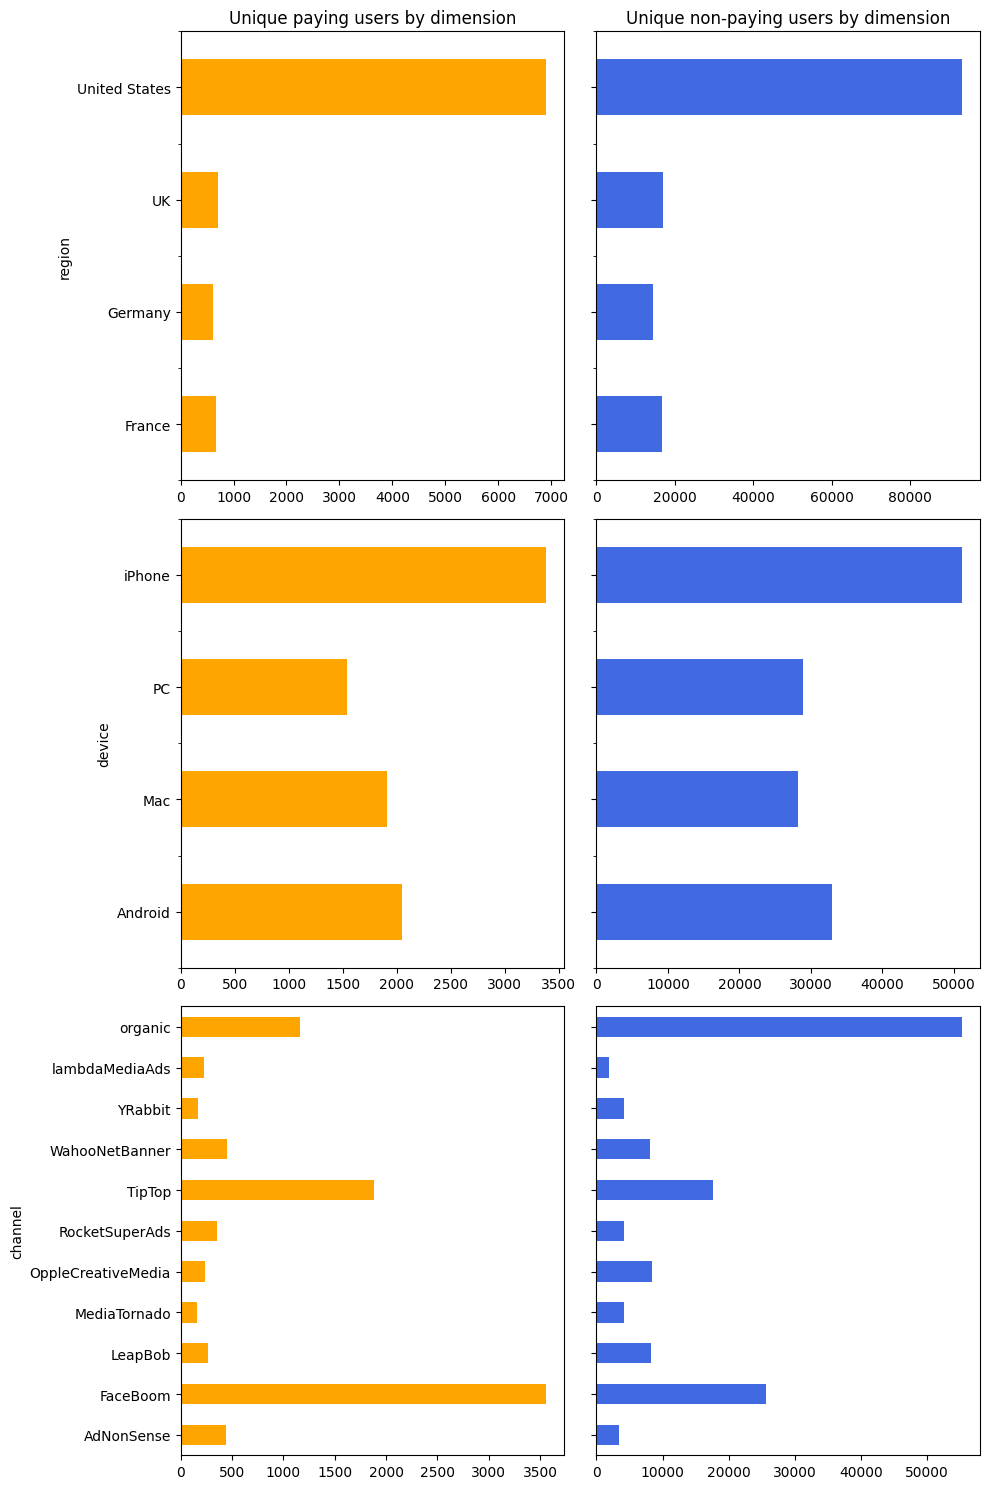

In [17]:
# Plot profiles.
fun_plot_profiles(df_profiles, ['region', 'device', 'channel']);

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️

Под долей платящих понимается соотношение числа платящих к числу пользователей, пришедших из конкретной страны, так например для `US` - это 6902 / 100002. Добавь, пожалуйста, эту метрику, она очень важна, для оценки каналов, стран, устройств</div>

<div class="alert alert-danger">
<b>Комментарий ревьюера v2:</b>☁️

`bar_label` не поддерживается на той версии `matplotlib`, которая актуальна для Практикума 
</div>


<div class="alert alert-danger">
<b>Комментарий ревьюера v3:</b>☁️

Возможно загрузилась не та версия, я не могу запустить весь проект, чтобы допроверить его, а корректное выполнение всех ячеек первое необходимое требование при приеме проекта
</div>


<div class="alert alert-info"> <b>Комментарий студента:</b>
    
% пользователей вА они в таблицах ниже? Или я что-то не так сделал?

</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера v4:</b>⛅️ 

Это не те доли платящих, я выше прикладывал пример расчёта для `US`
</div>

In [18]:
# The same but in tabular form.
def fun_get_percentage(profiles: pd.DataFrame,
                       dimesions=['region']):
    """
    This function pivots profiles table and prints a table with a % of unique paying users by dimension.

    Args:
        profiles (DataFrame): see fun_get_profiles for details.
        dimensions (list, optional): list of dimensions of interest. Defaults to ['region'].
    """
    for dimension in dimesions:
        df_pivoted = pd.pivot_table(data=profiles,
                                    index=dimension,
                                    values='user_id',
                                    columns='payer',
                                    aggfunc='count',
                                    margins=True,
                                    margins_name='Total')
        
        df_percentage = np.round(df_pivoted * 100 / df_pivoted.iloc[-1], 1) \
            .sort_values(by=True, ascending=False) \
            .reset_index() \
            .set_index(dimension)
            
        print('-' * 50)
        print('Paying users by ', dimension, ', %', sep='')
        print(df_percentage.iloc[1:, 0:2]) 
    
fun_get_percentage(df_profiles, ['region', 'device', 'channel'])

--------------------------------------------------
Paying users by region, %
payer          False  True 
region                     
United States   66.0   77.7
UK              12.0    7.9
France          11.9    7.5
Germany         10.2    6.9
--------------------------------------------------
Paying users by device, %
payer    False  True 
device               
iPhone    36.2   38.1
Android   23.4   23.1
Mac       19.9   21.5
PC        20.5   17.3
--------------------------------------------------
Paying users by channel, %
payer               False  True 
channel                         
FaceBoom             18.1   40.1
TipTop               12.5   21.1
organic              39.2   13.1
WahooNetBanner        5.7    5.1
AdNonSense            2.4    5.0
RocketSuperAds        2.9    4.0
LeapBob               5.9    3.0
OppleCreativeMedia    5.9    2.6
lambdaMediaAds        1.4    2.5
YRabbit               2.9    1.9
MediaTornado          3.0    1.8


Первые интересные наблюдения: США явно лидирует как источник платящих и неплатящих пользователей для нашего приложения. Остальные три страны - Великобритания, Германия и Франция приносят более-менее одинаковое количество пользователей. Распределение между странами похоже для обоих типов клиентов.

Ситуация c устройствами не такая драматичная, как со странами, но все равно есть на что посмотреть. Во-первых, есть девайс-лидер - это iPhone для обоих типов пользователей. Во-вторых, распределения разных типов пользователей по девайсам снова похожи.

Наконец, с каналами происходит самое интересное: здесь есть тройка лидеров, но она не одинаковая для плятящих и неплатящих пользоватлей. Так, большинство плятящих пользователей приходят к нам из FaceBoom, TipTop а также естественными путями. Большинство неплатящих пользователей к нам приходят органически (что, вероятно, логично), а также через FaceBoom и TipTop.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Да, про органику хочу отметить, что зачастую закупается трафик как раз с оптимизацией на то, чтобы эти пользователи приносили денег, поэтому столь ощутимая разница в проценте платящих с органическими пользователями, которые просто приходят)</div>


### Маркетинг

Дополнительно посмотрим:
1. Сколько денег потратили на рекламу? Всего / на каждый источник / по времени?
2. Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [19]:
# Total as spend.
print('Total ad spend in the period, $K:', round(df_costs.costs.sum() / 1e3, 1))

Total ad spend in the period, $K: 105.5


За весь период было потрачено 100 тысяч долларов на рекламу. Сложно сказать, это много или мало, пока не посмотрели на LTV или ROI, но сумма немаленькая. Посмотрим, как она была распределна по различным измерениям.

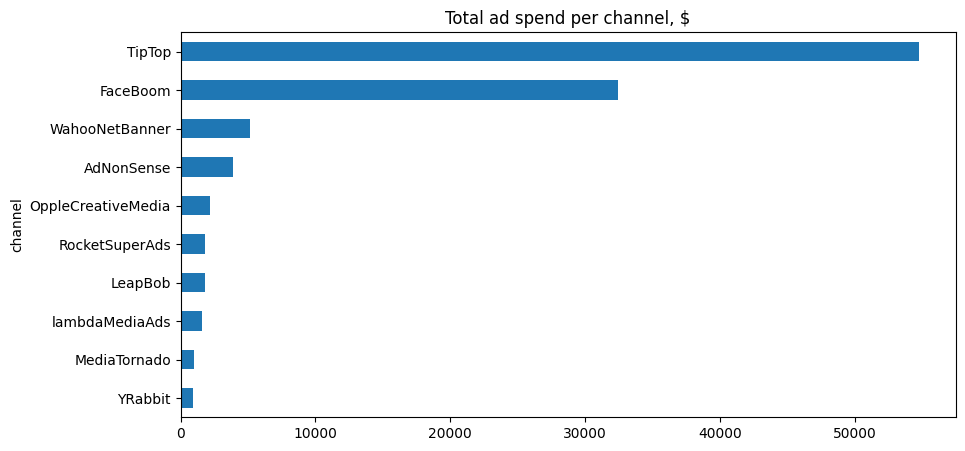

In [20]:
# Let's see ad spend per channel.
ax = pd.pivot_table(data=df_costs,
                    index='channel',
                    values='costs',
                    aggfunc='sum') \
       .sort_values(by='costs') \
       .plot(kind='barh',
             figsize=(FIG_WIDTH, FIG_HEIGHT),
             legend=False,
             title='Total ad spend per channel, $')

# ax.bar_label(ax.containers[0], label_type='edge', padding=5);
# ax.margins(x=0.2)

# plt.tick_params(axis='x',
#                 which='both',
#                 bottom=False,
#                 top=False,
#                 labelbottom=False)

А вот это уже интереснее. Больше всего денег мы угрохали в канал TipTop, хотя он не первый в нашем списке по количеству привлеченных клиентов. К этому вернемся, когда будем смотреть на средние изджерки на пользователя по каналам. Хвост остальных каналов в разы отстает от двух каналов-лидеров и более-менее равномерно убывает.

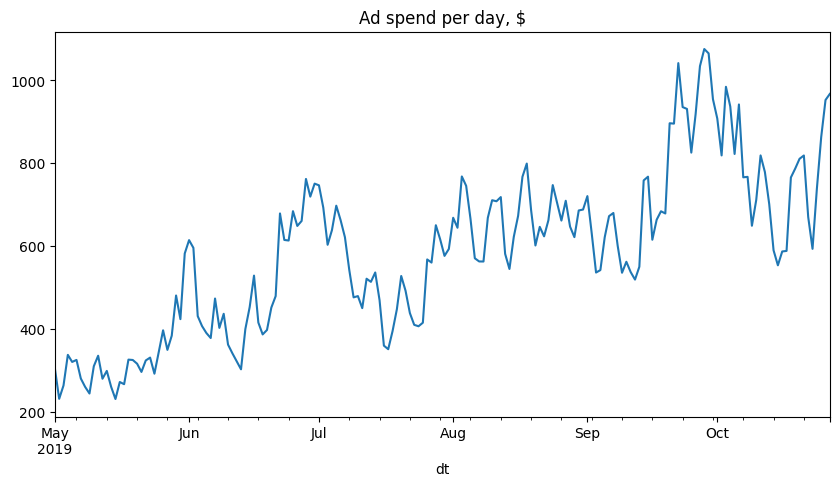

In [21]:
# Let's see ad spend per day.
ax = pd.pivot_table(data=df_costs,
                    index='dt',
                    values='costs',
                    aggfunc='sum') \
       .sort_values(by='dt') \
       .plot(kind='line',
             figsize=(FIG_WIDTH, FIG_HEIGHT),
             legend=False,
             title='Ad spend per day, $')


Не самый приятный график, который хотел бы видеть бизнес: наши затраты за 3 месяца выросли почти в три раза! Можно заметить некоторую "сезонность" - в июле, в середине сентября и октябре затраты увеличивались. Само по себе, растущие затраты могут не быть проблемой, ведь если выручка растет быстрее, то все довольны. Тем не менее, тренд настораживает.

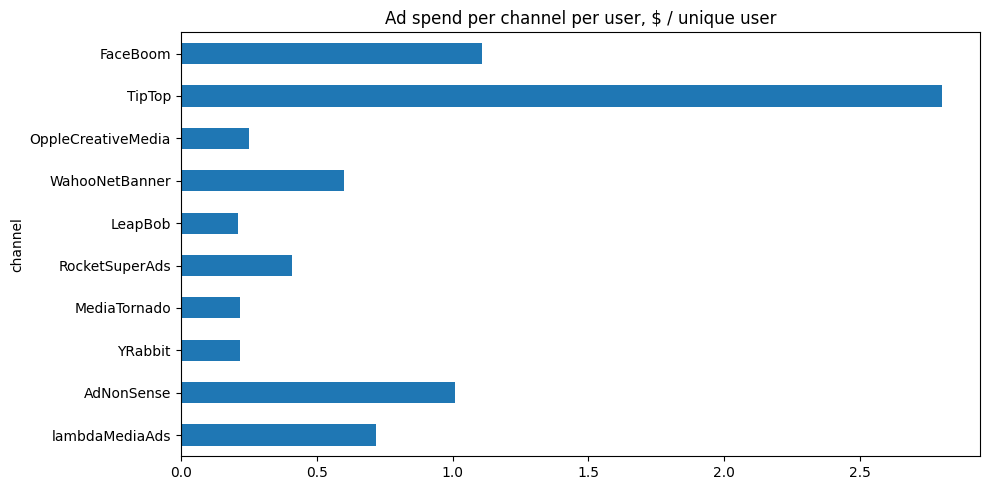

In [22]:
# Average ad spend per user per channel.
pvt_data_per_channel = pd.merge(left=pd.pivot_table(data=df_costs,
                                                    index='channel',
                                                    values='costs',
                                                    aggfunc='sum'),
                                right=pd.pivot_table(data=df_profiles,
                                                     index='channel',
                                                     values='user_id',
                                                     aggfunc='count'),
                                on='channel').rename(columns={'user_id': 'unique_users_count'})

pvt_data_per_channel['cost_per_user'] = round(pvt_data_per_channel.costs / pvt_data_per_channel.unique_users_count, 2)
pvt_data_per_channel = pvt_data_per_channel.sort_values(by='unique_users_count')

ax = pvt_data_per_channel[['cost_per_user']].plot(kind='barh',
                                                  figsize=(FIG_WIDTH, FIG_HEIGHT),
                                                  legend=False,
                                                  title='Ad spend per channel per user, $ / unique user')

# for containter in ax.containers:
#     ax.bar_label(containter, label_type='edge', padding=5);
#     ax.margins(x=0.2)

# plt.tick_params(axis='x',
#                 which='both',
#                 bottom=False,
#                 top=False,
#                 labelbottom=False)

plt.tight_layout()

А вот это самый инетересный график. Здесь каналы упорядочены по суммарному количеству привлеченных пользователей. Наш основной канал привлечения платящих пользователей - FaceBoom - сравним с менее значимым каналами. А вот TipTop опять попал в фокус - стоимость привлечения в нем более чем в два раза превышает значения FaceBoom. Возможно, он виноват в наших бедах?

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Он один из виновников, интересная сортировка, у меня до прочтения комментария уже потянулась рука попросить по убыванию, росту `CAC` отсортировать  </div>


## Окупаемость рекламы для привлечения пользователей

Посмотрим детальнее на результаты работы маркетологов. Для этого ответитм на вопросы:
1. Какая конверсия и удержание с разбивкой по устройствам, странам, рекламным каналам?
2. Окупается ли реклама, направленная на привлечение пользователей в целом? 
3. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
4. Чем могут быть вызваны проблемы окупаемости?

In [23]:
# Cut organic trafic from the datasets to avoid confusion
df_profiles = df_profiles[df_profiles.channel != 'organic']
df_visits = df_visits[df_visits.channel != 'organic']
df_orders = df_orders[df_orders.user_id.isin(df_profiles.user_id)]

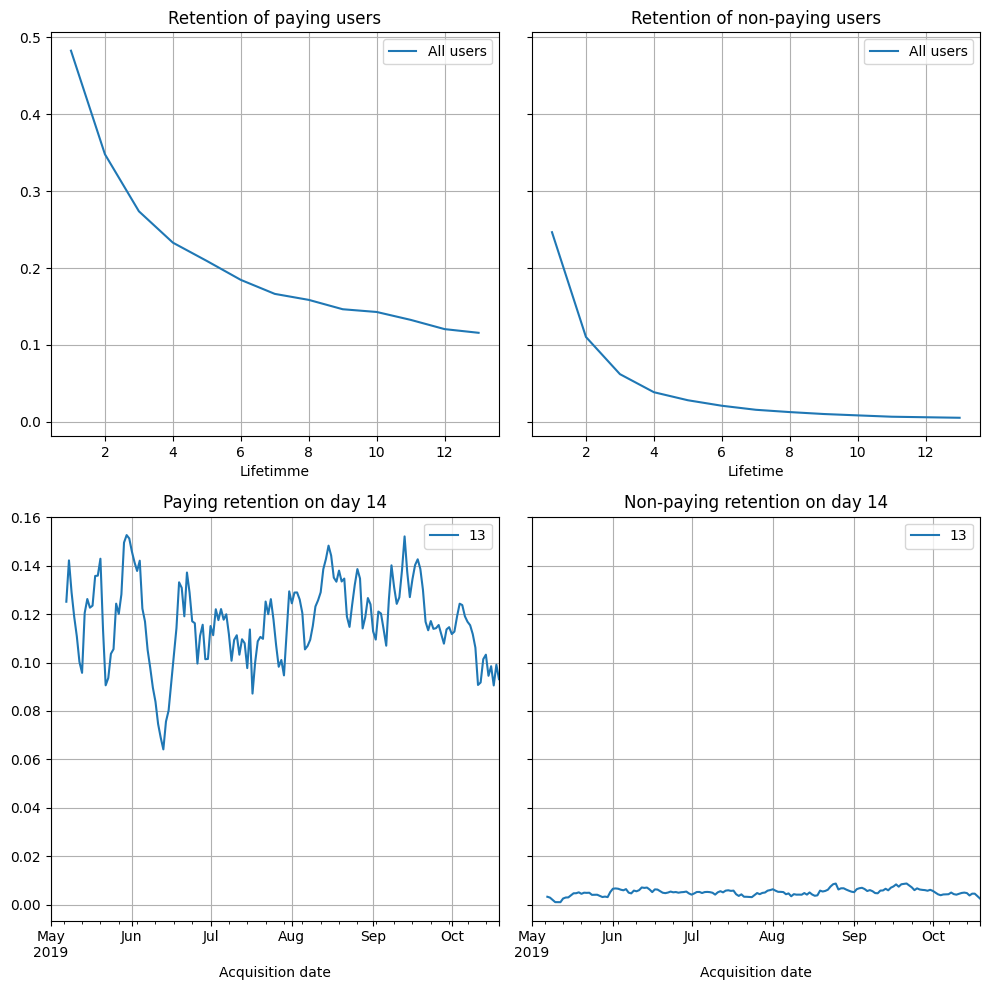

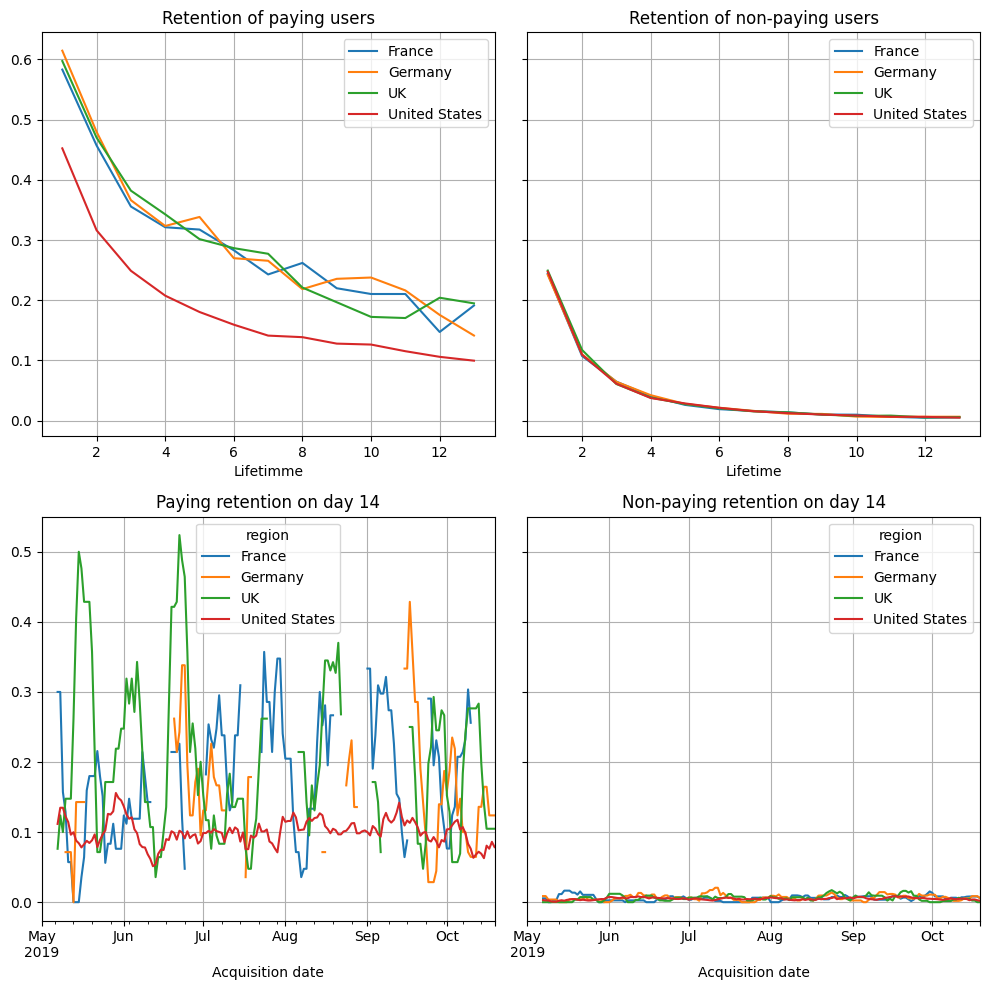

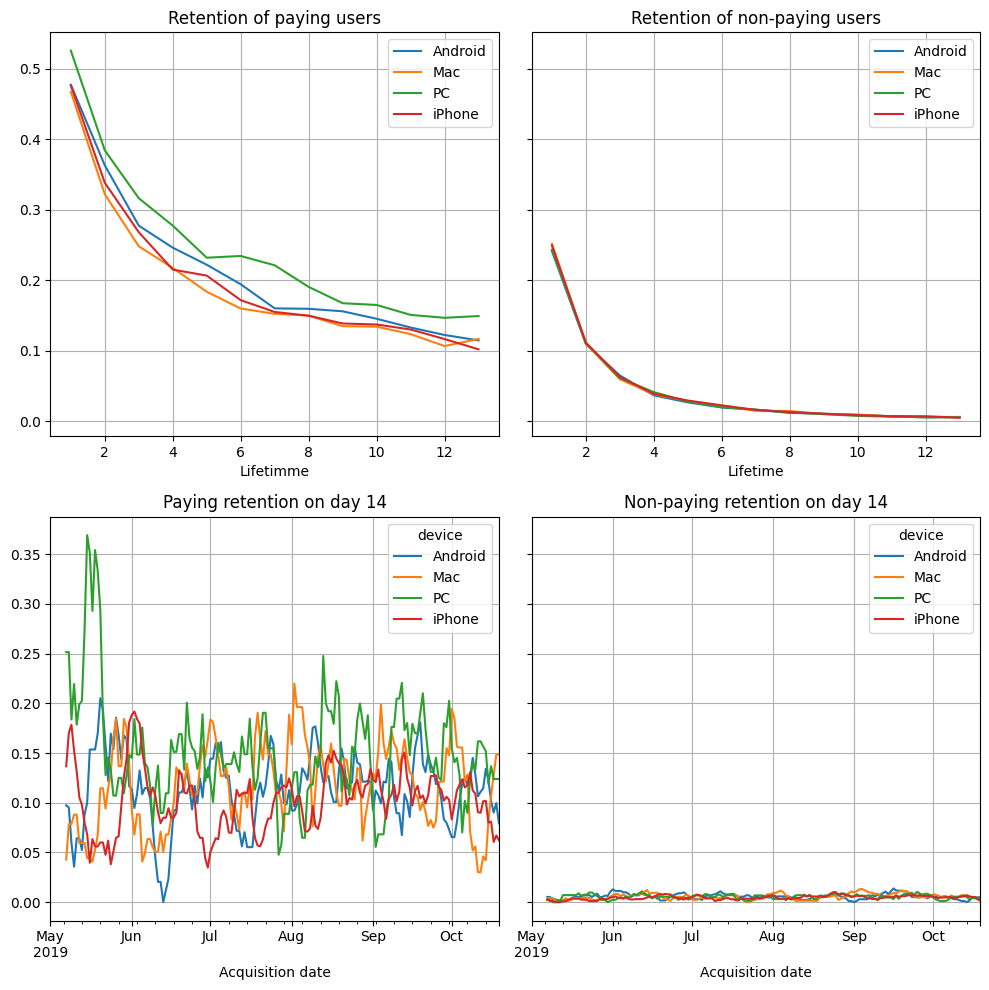

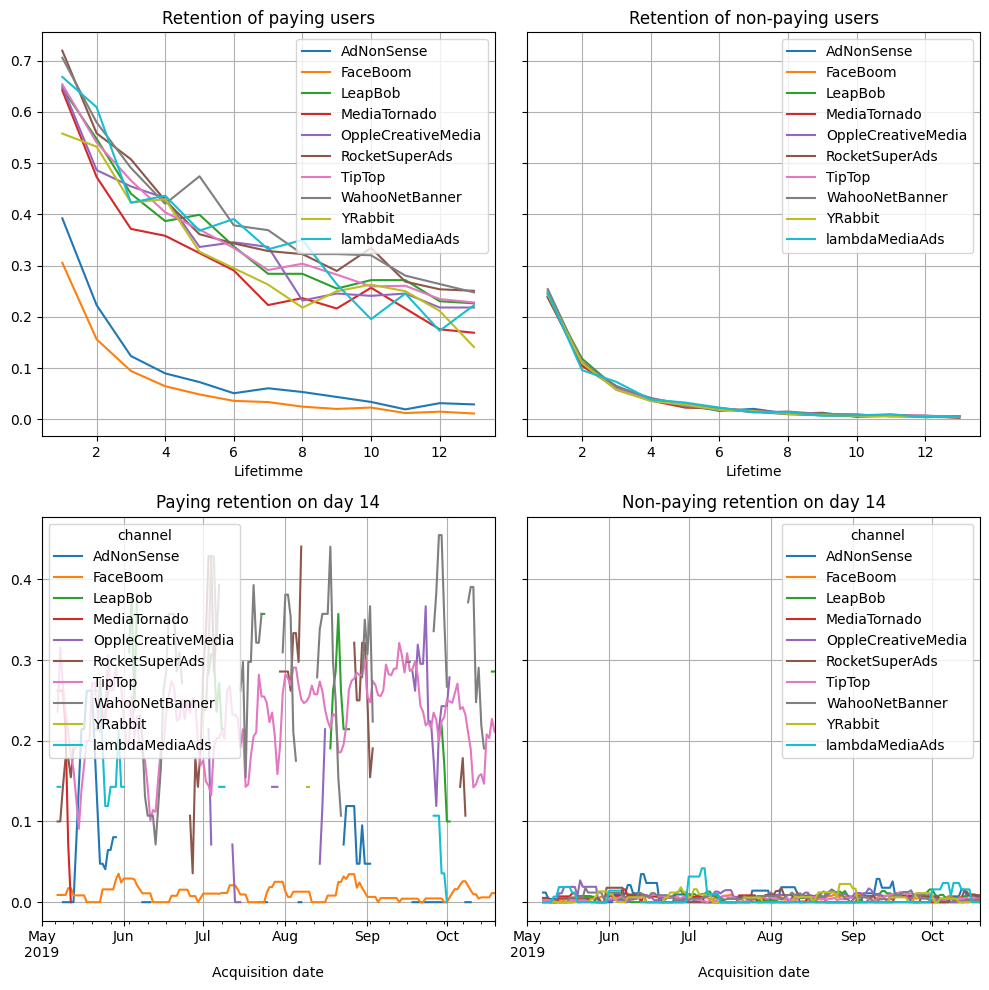

In [24]:
# Let's see how retention looks.
for dimension in [[], ['region'], ['device'], ['channel']]:
    df_retention_raw, \
    df_retention_by_dimension, \
    df_retention_by_dimension_in_time = fun_get_retention(df_profiles,
                                                          df_visits,
                                                          OBSERVATION_DATE,
                                                          HORIZON_DAYS,
                                                          dimensions=dimension)

    fun_plot_retention(df_retention_by_dimension,
                       df_retention_by_dimension_in_time,
                       HORIZON_DAYS)

<div class="alert alert-success">
<b>Комментарий ревьюера v4:</b>☀️
    
* Обрати внимание, что удержание неплатящих пользователей из разных каналов, стран, платформ ровное, а удержание платящих очень отличается, как считаешь почему так?
* Существенная проблема - плохое удержание в US, можно было подробнее посмотреть на всех ли каналах, которые приводят трафик в US, такая ситуация, анонсирую, что два самых крупных канала приводят трафик только из US, если захочешь, можешь поисследовать. 


<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️
    
Здесь и ниже при анализе стоит исключать органический трафик, мы не платим за этих пользователей, а доход от них может завышать довольно плачевную картину и скрыть от нас проблемы в какой-то стране или же типе устройств. Соответственно и выводы после этих правок могут поменяться, поэтому жду исключения из дальнейшего анализа всех органических пользователей и после этого прокомментирую оставшуюся часть проекта. </div>


В графиках суммарного удержания нету ничего необычного на первый взгляд: удержание платящих пользователей больше, чем удержание неплатящих пользователей и следует экспоненциальному закону. Удержание на 14 день немного менялось во времени, но это не выглядит существенным.

Но дальше все становится веселее:

1. Удержание неплатящих пользователей по лайфтайму одинаковое для разных срезов, хотя есть некоторые есть отличия в удержании на 14 день.

Удержание платящих пользователей сильно разнится по срезам:

1. США явно отстает от остальных регионов почти на 10% на всем лайфтайме. Также есть странные скачки в удержании на 14 день во Франции и Великобритании. Хорошо бы было понять с чем они связаны.

2. Удержание в зависимости от девайса меняется несильно, хотя есть явное устройство-лидер - ПК.

3. А вот с удержанием пользователей из каналов AdNonSense и FaceBoom происходит что-то трагичное: оно отличается на 30%-40% от остальных каналов на всем лайфтайме и падает почти до нуля на 13-14 день. Похоже, это явление было стабильным: удержание на 14 день для FaceBoom много раз равнялось нулю! Надо заметить, что были моменты (июнь, конец августа) когда удержание резко выростало. Еще одно наблюдение, которое хорошо бы поисследовать.

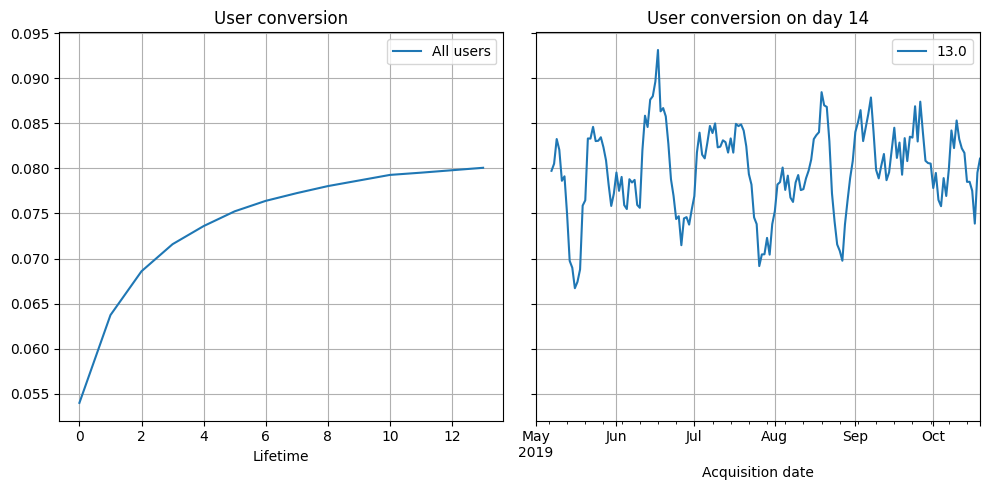

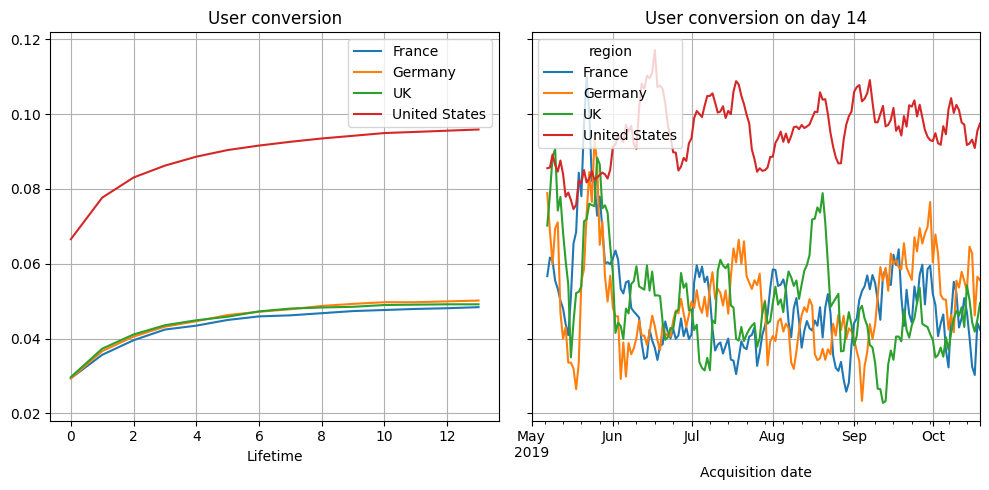

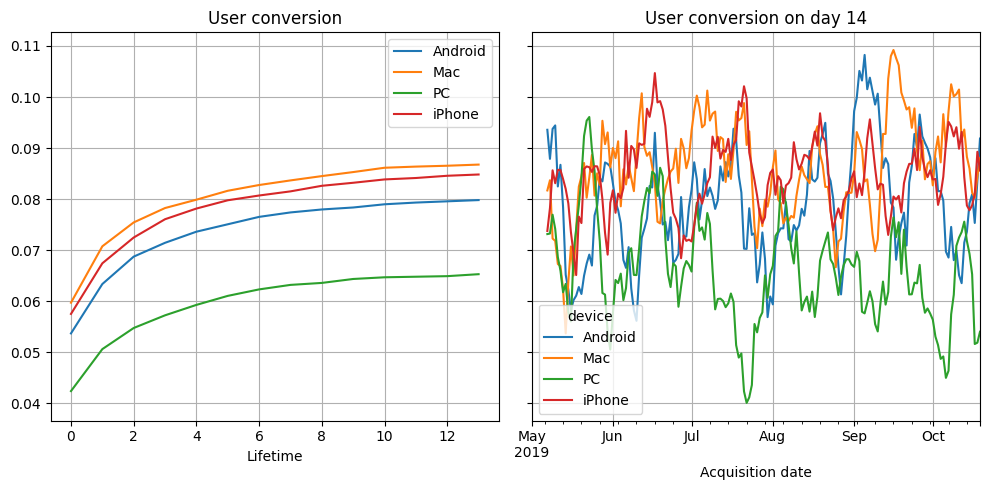

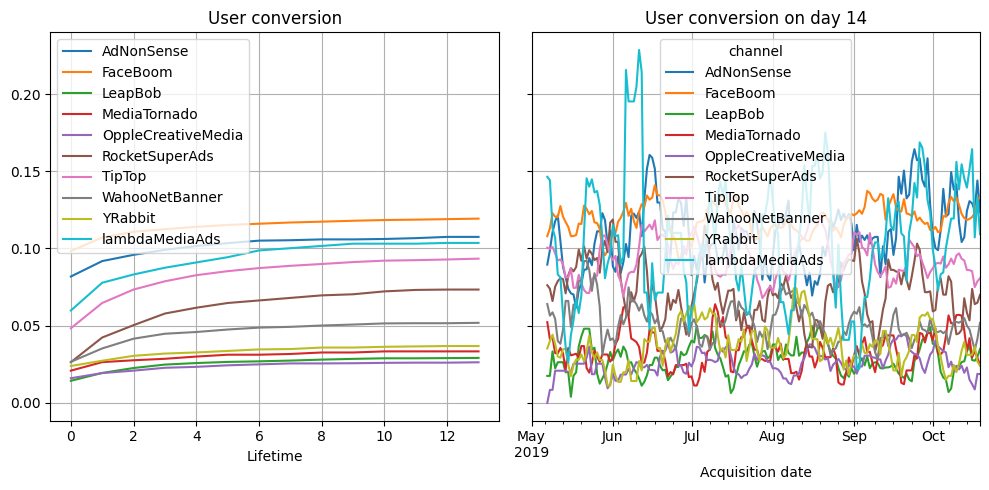

In [25]:
# Let's see how conversion looks.
for dimension in [[], ['region'], ['device'], ['channel']]:
    df_conversion_raw, \
    df_conversion_by_dimension, \
    df_conversion_by_dimension_in_time = fun_get_conversion(df_profiles,
                                                            df_orders,
                                                            OBSERVATION_DATE,
                                                            HORIZON_DAYS,
                                                            dimensions=dimension)

    fun_plot_conversion(df_conversion_by_dimension,
                        df_conversion_by_dimension_in_time,
                        HORIZON_DAYS)

<div class="alert alert-success">
<b>Комментарий ревьюера v4:</b>☀️
    
Любопытно, что динамика конверсии `US` становится с течением времени не такой волатильной. </div>

В графиках суммарной конверсии все относительно хорошо: конверсия в зависимости от лайфтайма растет по экспоненциальному закону. Конверсия на 14 день была на уровне 4.5% до июня, а потом выросла до 6%! Можно за нее порадоваться.

Это увелечение можно объяснить на срезах:

1. Хотя удержание в США страдает, конверсия в этой стране самая большая - почти на 2% больше на всем лайфтайме относительно остальных стран. Рост конверсии на 14 день в июне также объясняется ростом в США - с 5% до 7%. Как мы увидим ниже, это основаня причина роста суммарной конверсии.

2. Похожее можно сказать про девайсы: у нас хорошее удержание на ПК, а вот конверсия на всем лайфтайме самая маленькая. Она стабильно отстает как минимум на 1% от остальных устройств. Конверсия на 14 день во времени сильно меняется. У нас снова есть хорошее периоды (сентябрь-октябрь на Андроиде и Маке) и плохие (июль-август на ПК).

3. Ситуация снова повторяется с каналами: FaceBoom имеет самую большую конверсию на всем лайфтайме, следом идет AdNonSense. Любопытно побольше узнать о lambdaMediaAds - конверсия здесь очень близка к двум лидерам, а также есть интересные выбросы в конверсии на 14 день в июне-июле.


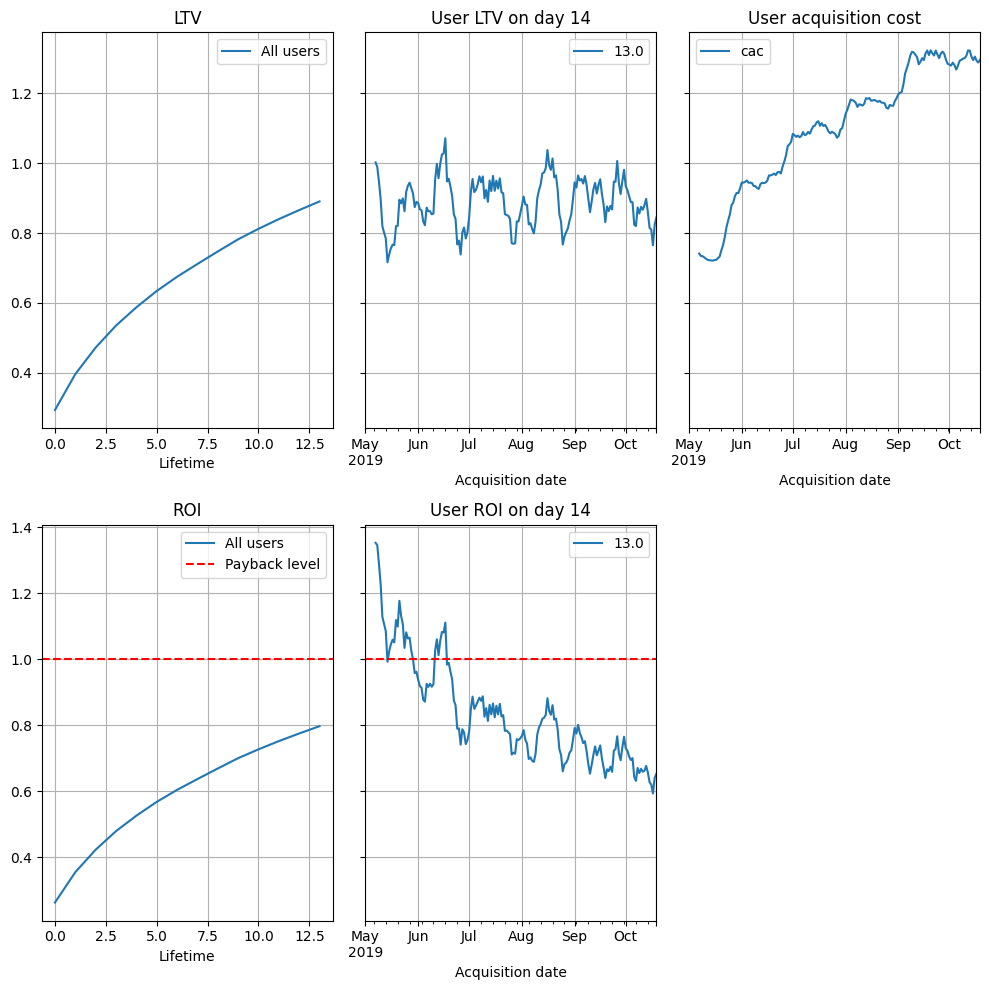

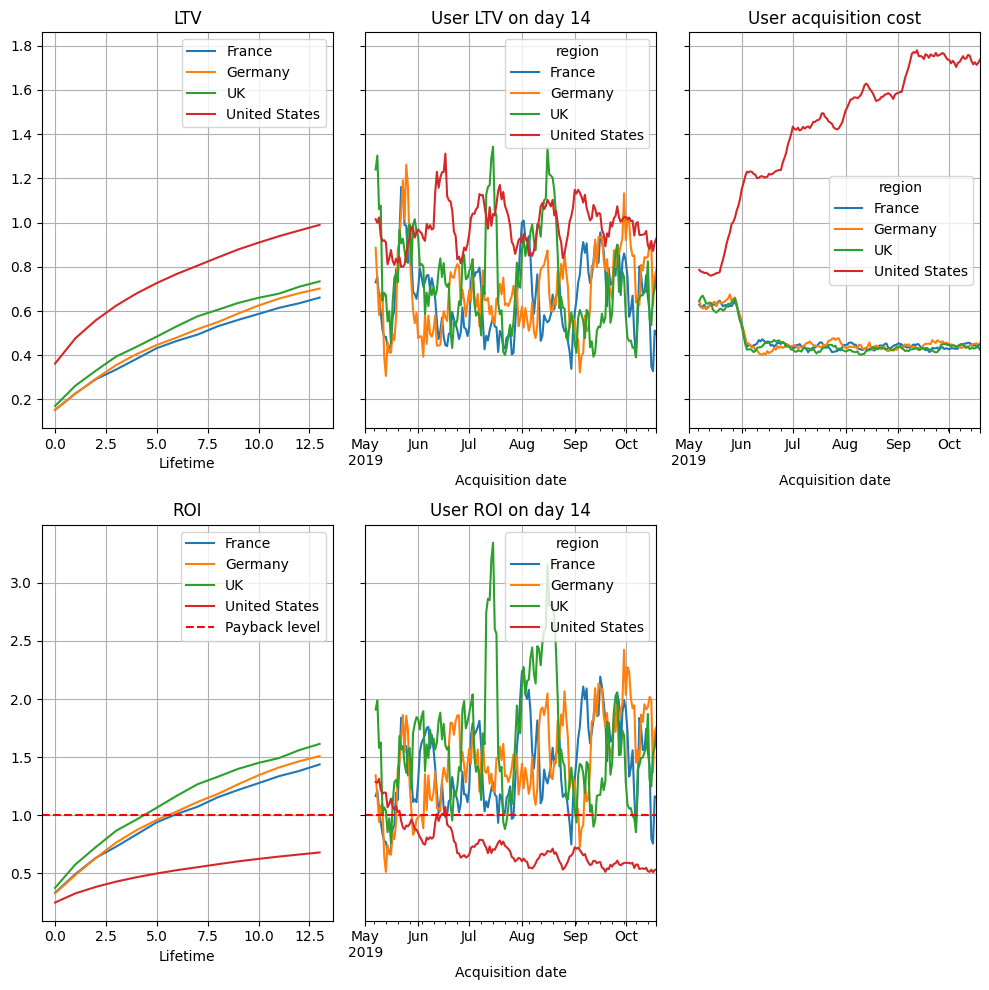

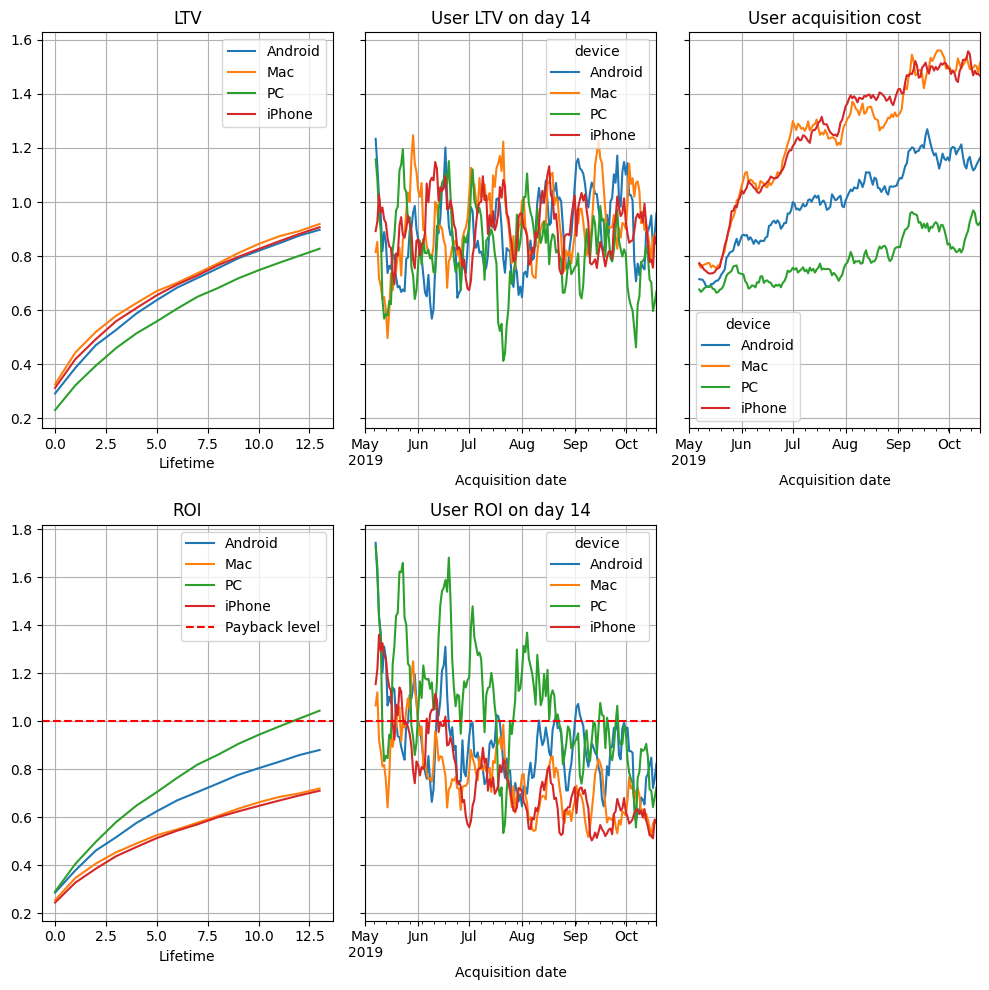

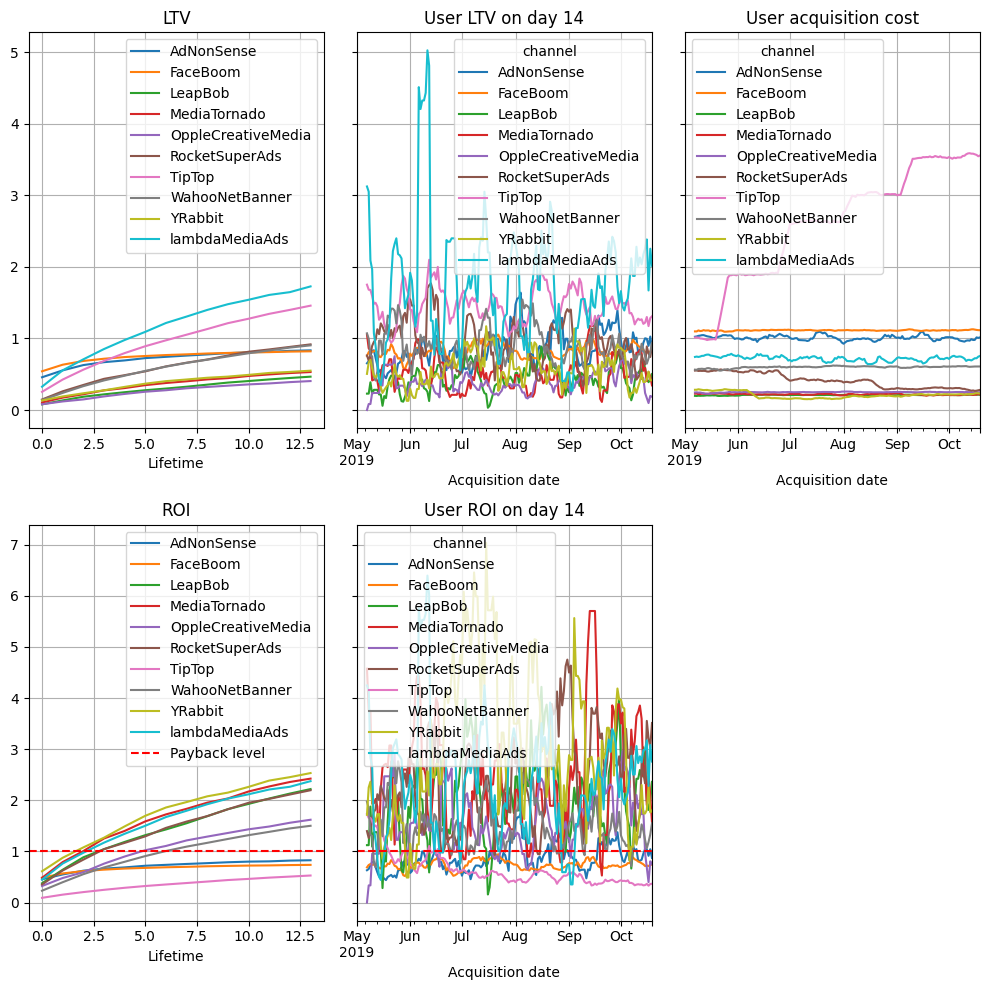

In [26]:
# Let's see how LTV and ROI looks.
for dimension in [[], ['region'], ['device'], ['channel']]:
    df_ltv_raw, \
    df_ltv_by_dimension, df_ltv_by_dimension_in_time, \
    df_roi_by_dimension, df_roi_by_dimension_in_time = fun_get_ltv(df_profiles,
                                                                   df_orders,
                                                                   OBSERVATION_DATE,
                                                                   HORIZON_DAYS,
                                                                   dimensions=dimension)
    
    fun_plot_ltv_roi(df_ltv_by_dimension,
                    df_ltv_by_dimension_in_time,
                    df_roi_by_dimension,
                    df_roi_by_dimension_in_time,
                    HORIZON_DAYS)

<div class="alert alert-success">
<b>Комментарий ревьюера v4:</b>☀️
    
* Хочу акцентировать твоё внимание на способе решения в данном случае комплексной задачи - неокупаемость маркетинга. Мы эту составную проблему раскладываем на частные причины, декомпозируем весь трафик по странам, устройствам, регионам и ищем где конкретно и в какой момент случилась проблема. 
    
* Чудеса декомпозиции,  отличный подход, который всегда приведёт к успеху, разобрались с LTV И ROI, получили явную проблему в US и TIp Top с Faceboom, при учете, что US - страна с наибольшим количеством пользователей, а Tip TOp и FaceBoom - крупнешие каналы для нас это важные находки, дальше с которыми стоит работать
</div>

Графики ROI, LTV и CAC раскрывают причины наших проблем:

1. Суммарное LTV на 14 день было довольно стабильным на промежутке, который у нас есть, а вот CAC сильно вырос в июне и продолжил расти дальше. Это оказало значительно влияние на ROI: показатель упал с `1.8` в мае до `0.8` в октябре.

2. В разрезе по странам мы видим, что USA имеет самый большой LTV по сравнению с другими регионами, но в USA и живет повышение CAC, которое мы видели на общем графике. В остальных регионах CAC был достаточно стабилен. По ROI видно, что во всех странах, кроме США наши усилия окупаются уже на 3 день, а также что ROI в США на 14 день стало меньше 1 как раз в тот момент, когда повысился CAC.

3. Ситуация по устройствам получилась размазанная: больше всего пострадали Маки и iPhone, но повышение CAC сказалось очень похоже на всех. Интересно, что даже после повышения CAC в два раза, наши усилия на ПК все равно более-менее окупаются.

4. Последние графики в разрезе по каналам показывают, что причиной такого сильно повышения CAC является канал TipTop: CAC в TipTop вырос с `1.1` до `3.5` за время наблюдения. Т.к. это наш второй по величине канал привлечения пользователей - это объясняет почему мы теряем деньги. Интересно, что остальные два канала AdNonSense и FaceBoom также работали в убыток все это время.

## Выводы

Подведем итоги:

1. У нашего бизнеса есть проблема: за 6 месяцев наблюдений LTV на 14 день стабильно колебалось вокруг значения `0.65`, а в то же время САС вырос более чем в два раза с `0.33` до `0.85`. Это привело к пропорциональному падению ROI с `1.8` до `0.8`.

2. Рост суммарного CAC вызван ростом CAC в канале TipTop с `1.1` до `3.5` в США. Т.к. это второй канал и первая страна по количеству привлеченных пользователей, он толкает весь бизнес к ROI < 1.

3. Два других больших канала по количеству привлеченных пользователей: FaceBoom и AdNonSense были неприбыльными за все время наблюдений, несмотря на то, что LTV и СAC для них оставался более-менее постоянным.

Что с того:

1. Нам следует пересмотреть основные каналы для привлечения пользователей в США. Исходя из суммарных значений, CAC в канале должен быть менее `0.8`, чтобы ROI > 1.

2. Потенциальным кандидатами могут быть каналы YRabbit, MediaTornado и lambdaMediaAds. У них у всех ROI превышает `2` уже на 10 день лайфтайма.

Для искушенных:

1. Хорошо бы понять почему FaceBoom и TipTop были выбраны как каналы привлечения изначально. Использование неприбыльных каналов может быть оправдано, если они позволяют создавать большой трафик (например, это может быть нужно при изначальном запуске продукта).

2. Итоги #2 и #3 можно дополнить, если построить как меняется LTV, CAC и ROI по каналам внутри США. Это поможет добавить аргументов нашим наблюдениям.

<div class="alert alert-success">
<b>Комментарий ревьюера v4:</b>☀️
    
* Все критические замечания исправлены, принимаю проект, ты молодец). Касательно рекомендаций, не хватает связи каналов и стран, ведь пользователь пришедший из `US` пришел с какого-то канала, вот этот кусочек пазла позволит получить общую картину. Ну и я считаю важной рекомендацией - чаще обращать внимания на показатели маркетинга, а то очень похоже, что маркетинговый отдел долгое время сжигал деньги не очень эффективно). В работе я оставил некоторое количество мелких рекомендаций от себя, надеюсь ты из них вынесешь что-то для себя и будешь активно применять в будущих проектах и работе.) Рекомендую поработать над оформлением теста `markdown` разметкой и особенно распространить оглавление, его можно сделать более подробным, что упростит навигацию по проекту, сейчас твоё оглавление выглядит так 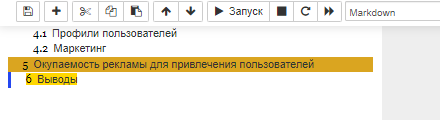
    
* О том, как **форматировать текст** в Markdown ячейке или как добавлять ссылки, ты можешь узнать [тут](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet) и [вот тут](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).
    
* В части по анализу графиков я оставил несколько вопросов, но так как проект я принимаю не хочу оставлять тебя без ответов. В более ровном удержании виновато число пользователей. Когда говорим об удержании платящих, видим величину волатильную, но это не из-за её природы, а из-за того, что наблюдений мало, и каждое отдельное наблюдение существенно влияет на оценку, такая особенность часто может проявляться в анализе, так что рекомендую проверять число наблюдений, чтобы не ошибаться с выводами.
   
* Сейчас работаю аналитиком в отделе закупки игровой компании и US это действительно наибольший рынок, ему достается процентов 30-40 всего трафика, да набор каналов существенно шире, но US доминирует в этом плане. Конечно у нас перед глазами набор дашбордов, которые позволяют контролировать множество всяких метрик, но периодически бывает всякое, конечно же масштабирование канала, который становится всё хуже и хуже - сомнительная идея, а оптимизации происходят существенно чаще, по некоторым каналам раз в неделю, а по некоторым и ещё чаще). Благодарю за совместную работу, желаю удачи!) 
    
</div>